In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter




In [ ]:
print(f"Dataset shape: {df.shape}")
print(f"Fraud rate: {df['Class'].mean():.6f}")
print("\nDataset sample:")
display(df.head())

Dataset shape: (984, 33)
Fraud rate: 0.500000

Dataset sample:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,hour,amount_log,Class
138028,82450.0,0.656444,-0.333750,0.462947,-0.480585,0.439336,-0.231518,0.541927,-0.119652,0.487148,...,-0.109814,-0.248843,0.896138,0.825081,-0.125281,-0.012024,-0.453503,1.474016,-0.700987,0
63099,50554.0,0.273646,-0.171934,0.716463,-0.487441,0.419604,0.235537,0.560130,-0.031604,0.218698,...,-0.067627,0.120820,-0.413036,-0.834735,-0.487386,-0.360542,-0.438074,0.206018,-0.650569,0
73411,55125.0,0.347470,-0.561369,0.751563,-1.112290,0.215251,0.425548,0.355340,-0.065901,-0.579990,...,-0.153127,-0.747298,-0.506585,-0.008253,0.072974,0.489060,-0.389258,0.364517,-0.499721,0
164247,116572.0,0.407398,-0.204600,0.411179,-0.713310,0.409453,-0.360754,0.608122,-0.032515,0.479626,...,-0.004221,-0.121095,-0.551136,-0.345495,-0.114582,0.013615,-0.199772,-0.744981,-0.010394,0
148999,90434.0,0.753156,-0.392896,0.613957,0.501887,0.388442,0.982748,0.351807,-0.011692,0.835760,...,0.180980,1.293603,-0.354022,-0.070913,-0.110766,-0.191291,-0.456932,-1.854480,-0.712384,0


In [ ]:
# Step 3: Data preprocessing
# Handle class imbalance
print("\nClass distribution before sampling:", Counter(df['Class']))
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(df.drop('Class', axis=1), df['Class'])
df = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res, columns=['Class'])], axis=1)
print("Class distribution after sampling:", Counter(df['Class']))

# Feature engineering
df['hour'] = df['Time'] % (24*60*60) // (60*60)
df['amount_log'] = np.log1p(df['Amount'] + 1e-5)  # Add small constant to avoid log(0)

# Select final features
FEATURE_COLS = [f'V{i}' for i in range(1, 29)] + ['hour', 'amount_log']
print(f"\nUsing {len(FEATURE_COLS)} features")

# Scale features
scaler = StandardScaler()
df[FEATURE_COLS] = scaler.fit_transform(df[FEATURE_COLS])


Class distribution before sampling: Counter({0: 492, 1: 492})
Class distribution after sampling: Counter({0: 492, 1: 492})

Using 30 features


In [ ]:
# Step 4: Create dataset and data loaders
class CreditCardDataset(torch.utils.data.Dataset):
    def __init__(self, df, feature_cols):
        self.df = df
        self.feature_cols = feature_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        features = torch.tensor(row[self.feature_cols].values, dtype=torch.float)
        label = torch.tensor(row['Class'], dtype=torch.float)
        return features, label

# Split data
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['Class'], random_state=42)
train_dataset = CreditCardDataset(train_df, FEATURE_COLS)
test_dataset = CreditCardDataset(test_df, FEATURE_COLS)

print(f"\nTraining samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")


Training samples: 688
Testing samples: 296


In [ ]:
# Step 5: Create model architecture
class FraudDetector(nn.Module):
    def __init__(self, input_size):
        super(FraudDetector, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        return torch.sigmoid(self.fc4(x))


In [ ]:
# Step 6: Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FraudDetector(len(FEATURE_COLS)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [ ]:
# Step 7: Focal loss for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return focal_loss.mean()

criterion = FocalLoss()


In [ ]:
# Step 8: Training function
def train(epoch):
    model.train()
    total_loss = 0
    predictions = []
    labels_list = []

    for batch_idx, (features, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        features = features.to(device)
        labels = labels.to(device)

        out = model(features)
        loss = criterion(out.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Collect for metrics
        predictions.extend(out.squeeze().detach().cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(features)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # Calculate metrics
    auc = roc_auc_score(labels_list, predictions)
    return total_loss / len(train_loader), auc


In [ ]:
# Step 9: Evaluation function - FIXED TO RETURN VALUES
def evaluate(loader):
    model.eval()
    predictions = []
    labels_list = []

    with torch.no_grad():
        for features, labels in loader:
            features = features.to(device)
            labels = labels.to(device)

            out = model(features)
            predictions.extend(out.squeeze().cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    # Calculate metrics
    auc = roc_auc_score(labels_list, predictions)
    pred_classes = [1 if p > 0.50 else 0 for p in predictions]
    cm = confusion_matrix(labels_list, pred_classes)
    report = classification_report(labels_list, pred_classes, target_names=['Legit', 'Fraud'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legit', 'Fraud'],
                yticklabels=['Legit', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:")
    print(report)

    return auc, cm  # FIXED: Return values instead of None

In [ ]:
# Step 10: Create data loaders
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)



Starting training...
Epoch: 1 [0/688 (0%)]	Loss: 0.055691


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


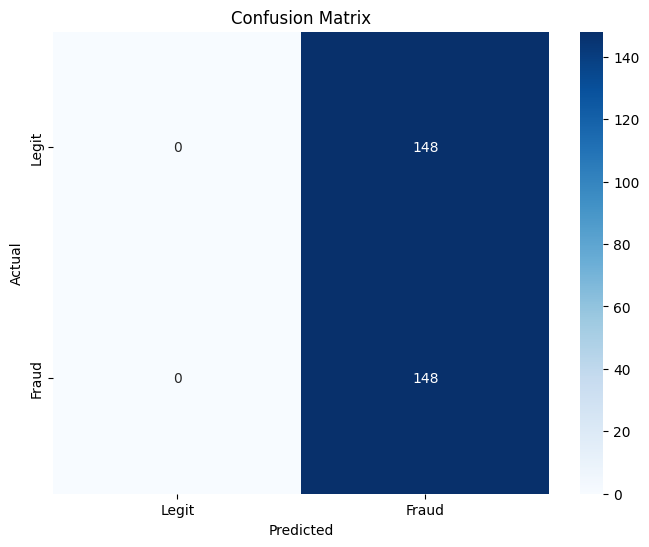

Classification Report:
              precision    recall  f1-score   support

       Legit       0.00      0.00      0.00       148
       Fraud       0.50      1.00      0.67       148

    accuracy                           0.50       296
   macro avg       0.25      0.50      0.33       296
weighted avg       0.25      0.50      0.33       296


Epoch 01: Train Loss: 0.0501, Train AUC: 0.5198, Test AUC: 0.8718
Epoch: 2 [0/688 (0%)]	Loss: 0.038690


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


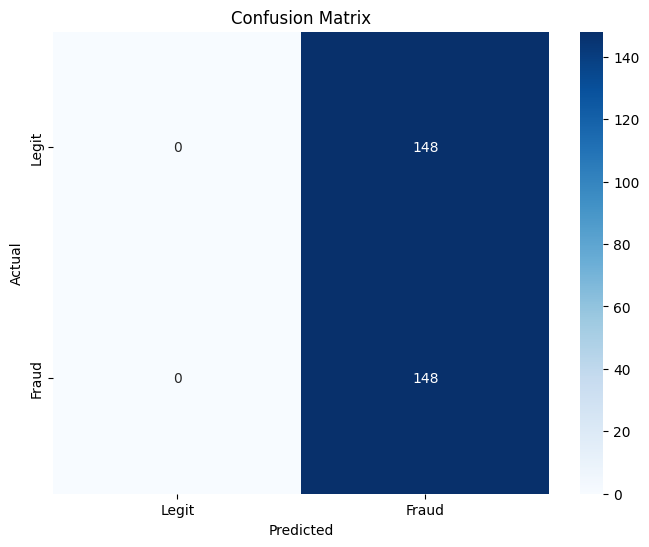

Classification Report:
              precision    recall  f1-score   support

       Legit       0.00      0.00      0.00       148
       Fraud       0.50      1.00      0.67       148

    accuracy                           0.50       296
   macro avg       0.25      0.50      0.33       296
weighted avg       0.25      0.50      0.33       296


Epoch 02: Train Loss: 0.0369, Train AUC: 0.7503, Test AUC: 0.9346
Epoch: 3 [0/688 (0%)]	Loss: 0.033224


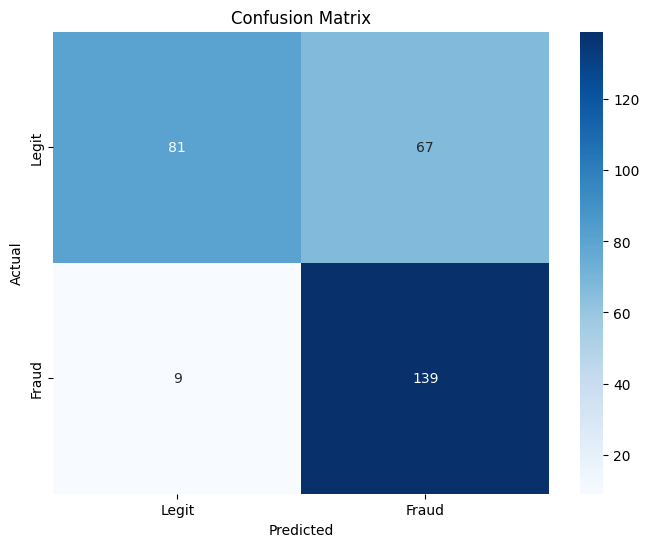

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.55      0.68       148
       Fraud       0.67      0.94      0.79       148

    accuracy                           0.74       296
   macro avg       0.79      0.74      0.73       296
weighted avg       0.79      0.74      0.73       296


Epoch 03: Train Loss: 0.0312, Train AUC: 0.8483, Test AUC: 0.9410
Epoch: 4 [0/688 (0%)]	Loss: 0.027282


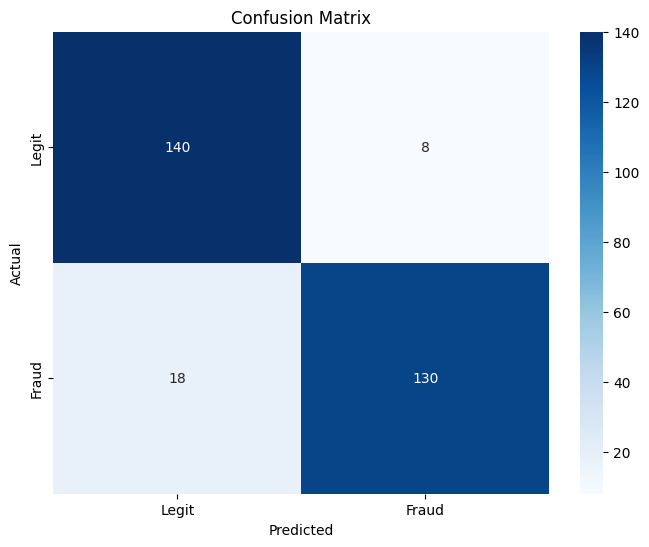

Classification Report:
              precision    recall  f1-score   support

       Legit       0.89      0.95      0.92       148
       Fraud       0.94      0.88      0.91       148

    accuracy                           0.91       296
   macro avg       0.91      0.91      0.91       296
weighted avg       0.91      0.91      0.91       296


Epoch 04: Train Loss: 0.0271, Train AUC: 0.8971, Test AUC: 0.9447
Epoch: 5 [0/688 (0%)]	Loss: 0.025391


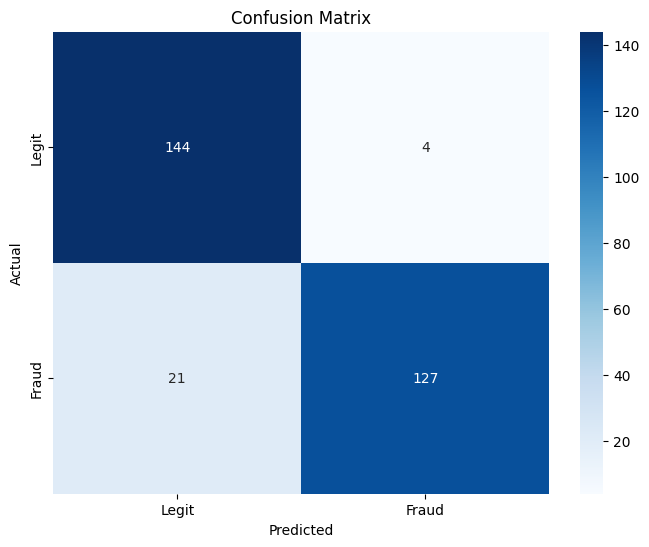

Classification Report:
              precision    recall  f1-score   support

       Legit       0.87      0.97      0.92       148
       Fraud       0.97      0.86      0.91       148

    accuracy                           0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296


Epoch 05: Train Loss: 0.0255, Train AUC: 0.9191, Test AUC: 0.9479
Epoch: 6 [0/688 (0%)]	Loss: 0.024968


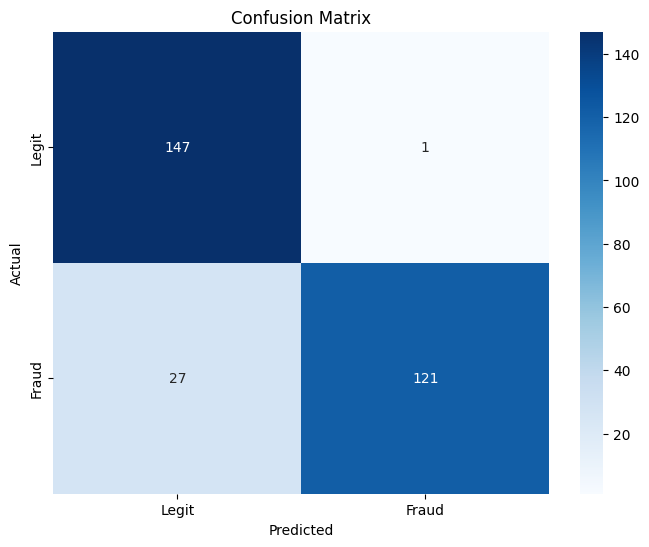

Classification Report:
              precision    recall  f1-score   support

       Legit       0.84      0.99      0.91       148
       Fraud       0.99      0.82      0.90       148

    accuracy                           0.91       296
   macro avg       0.92      0.91      0.90       296
weighted avg       0.92      0.91      0.90       296


Epoch 06: Train Loss: 0.0237, Train AUC: 0.9338, Test AUC: 0.9506
Epoch: 7 [0/688 (0%)]	Loss: 0.023271


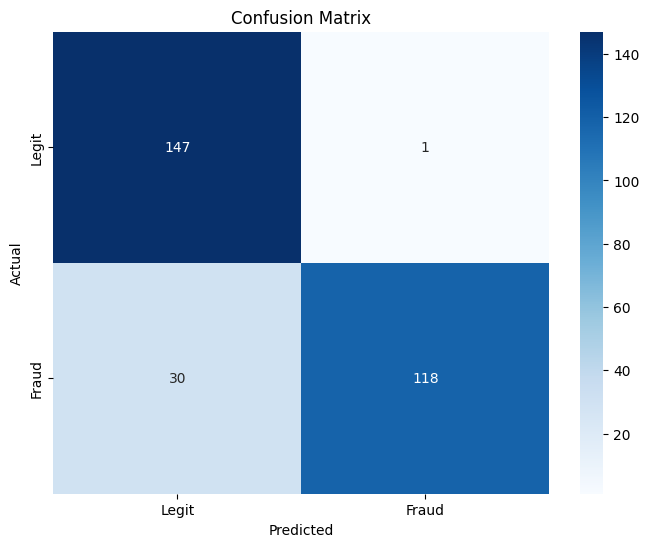

Classification Report:
              precision    recall  f1-score   support

       Legit       0.83      0.99      0.90       148
       Fraud       0.99      0.80      0.88       148

    accuracy                           0.90       296
   macro avg       0.91      0.90      0.89       296
weighted avg       0.91      0.90      0.89       296


Epoch 07: Train Loss: 0.0230, Train AUC: 0.9347, Test AUC: 0.9532
Epoch: 8 [0/688 (0%)]	Loss: 0.022985


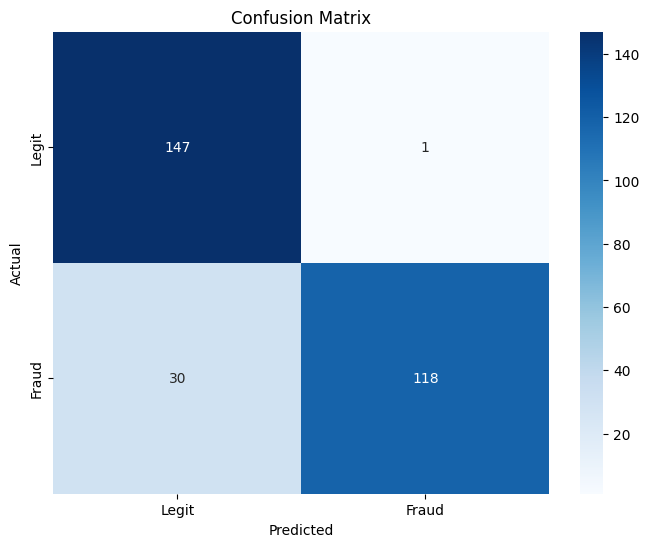

Classification Report:
              precision    recall  f1-score   support

       Legit       0.83      0.99      0.90       148
       Fraud       0.99      0.80      0.88       148

    accuracy                           0.90       296
   macro avg       0.91      0.90      0.89       296
weighted avg       0.91      0.90      0.89       296


Epoch 08: Train Loss: 0.0211, Train AUC: 0.9410, Test AUC: 0.9572
Epoch: 9 [0/688 (0%)]	Loss: 0.021072


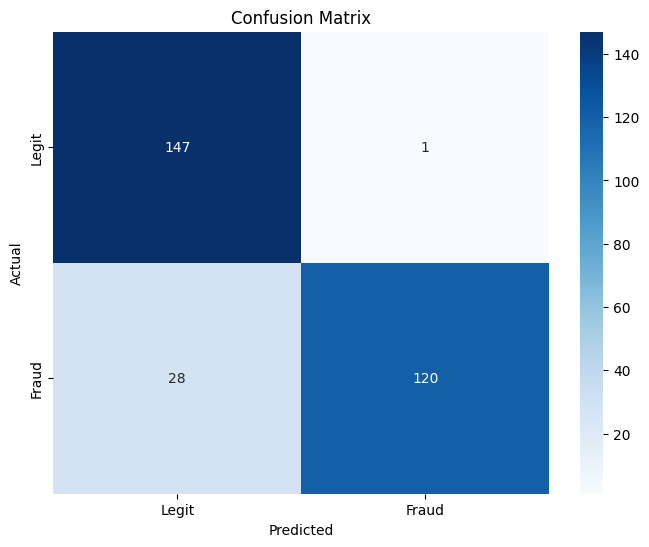

Classification Report:
              precision    recall  f1-score   support

       Legit       0.84      0.99      0.91       148
       Fraud       0.99      0.81      0.89       148

    accuracy                           0.90       296
   macro avg       0.92      0.90      0.90       296
weighted avg       0.92      0.90      0.90       296


Epoch 09: Train Loss: 0.0203, Train AUC: 0.9511, Test AUC: 0.9596
Epoch: 10 [0/688 (0%)]	Loss: 0.018932


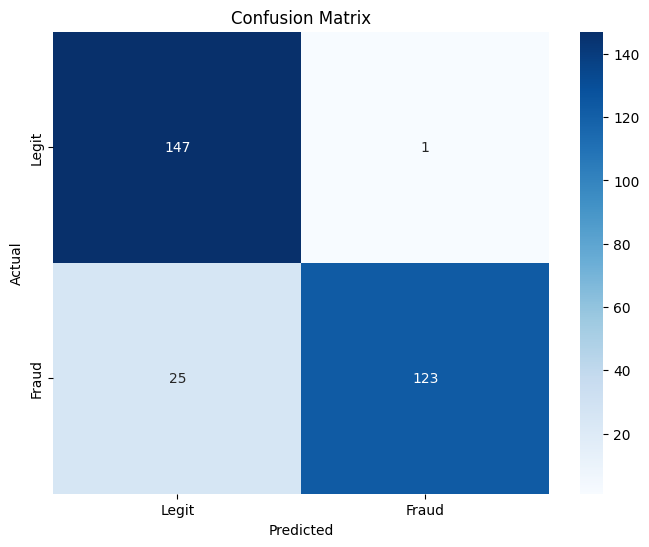

Classification Report:
              precision    recall  f1-score   support

       Legit       0.85      0.99      0.92       148
       Fraud       0.99      0.83      0.90       148

    accuracy                           0.91       296
   macro avg       0.92      0.91      0.91       296
weighted avg       0.92      0.91      0.91       296


Epoch 10: Train Loss: 0.0195, Train AUC: 0.9518, Test AUC: 0.9625
Epoch: 11 [0/688 (0%)]	Loss: 0.020371


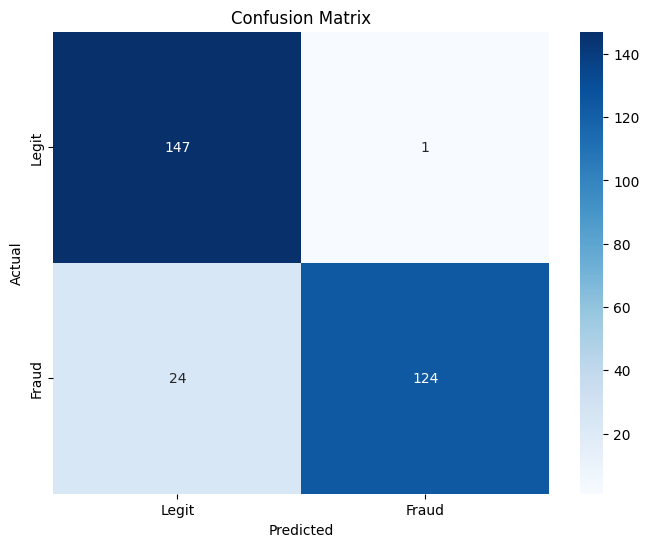

Classification Report:
              precision    recall  f1-score   support

       Legit       0.86      0.99      0.92       148
       Fraud       0.99      0.84      0.91       148

    accuracy                           0.92       296
   macro avg       0.93      0.92      0.92       296
weighted avg       0.93      0.92      0.92       296


Epoch 11: Train Loss: 0.0178, Train AUC: 0.9602, Test AUC: 0.9643
Epoch: 12 [0/688 (0%)]	Loss: 0.017610


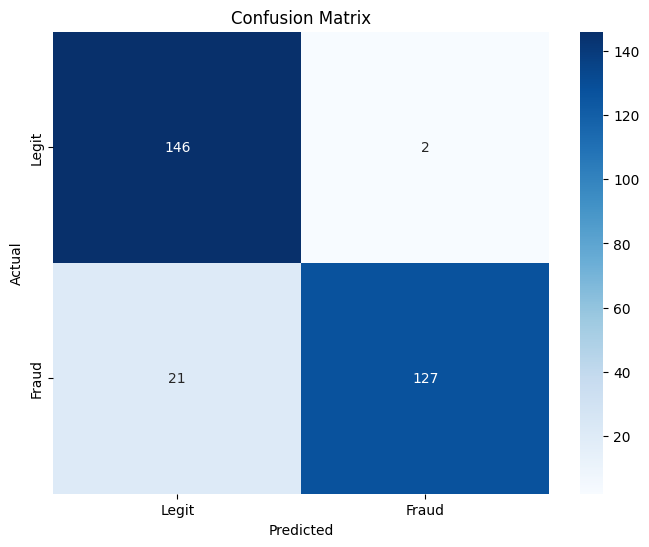

Classification Report:
              precision    recall  f1-score   support

       Legit       0.87      0.99      0.93       148
       Fraud       0.98      0.86      0.92       148

    accuracy                           0.92       296
   macro avg       0.93      0.92      0.92       296
weighted avg       0.93      0.92      0.92       296


Epoch 12: Train Loss: 0.0177, Train AUC: 0.9574, Test AUC: 0.9659
Epoch: 13 [0/688 (0%)]	Loss: 0.014720


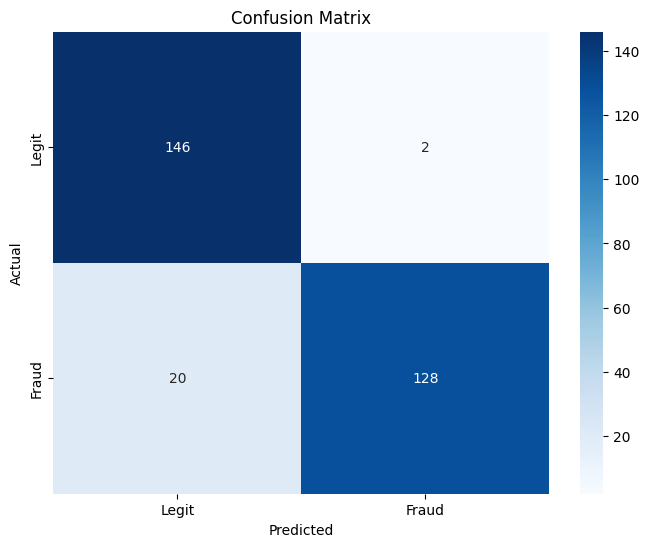

Classification Report:
              precision    recall  f1-score   support

       Legit       0.88      0.99      0.93       148
       Fraud       0.98      0.86      0.92       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 13: Train Loss: 0.0157, Train AUC: 0.9733, Test AUC: 0.9682
Epoch: 14 [0/688 (0%)]	Loss: 0.014759


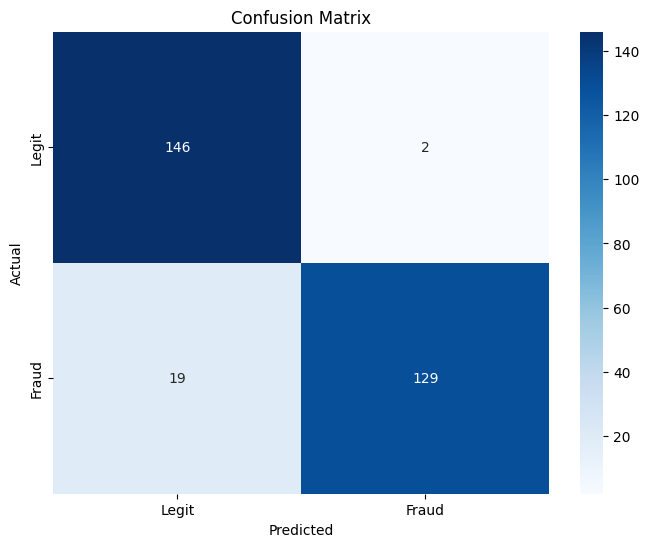

Classification Report:
              precision    recall  f1-score   support

       Legit       0.88      0.99      0.93       148
       Fraud       0.98      0.87      0.92       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 14: Train Loss: 0.0151, Train AUC: 0.9699, Test AUC: 0.9691
Epoch: 15 [0/688 (0%)]	Loss: 0.015533


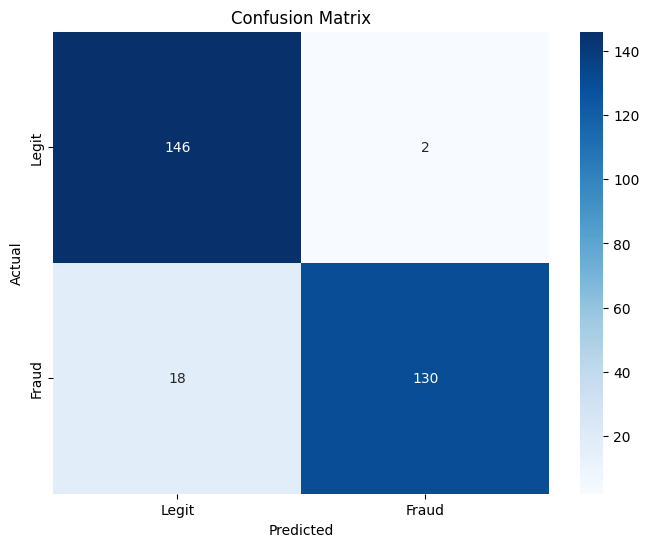

Classification Report:
              precision    recall  f1-score   support

       Legit       0.89      0.99      0.94       148
       Fraud       0.98      0.88      0.93       148

    accuracy                           0.93       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.93      0.93       296


Epoch 15: Train Loss: 0.0142, Train AUC: 0.9716, Test AUC: 0.9702
Epoch: 16 [0/688 (0%)]	Loss: 0.013517


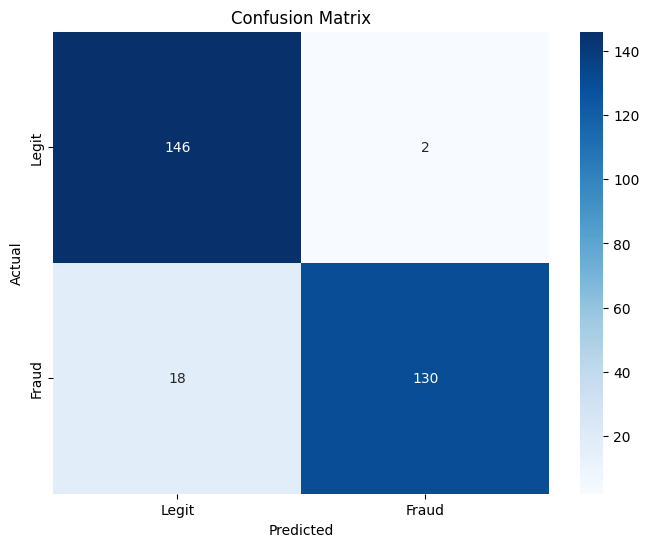

Classification Report:
              precision    recall  f1-score   support

       Legit       0.89      0.99      0.94       148
       Fraud       0.98      0.88      0.93       148

    accuracy                           0.93       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.93      0.93       296


Epoch 16: Train Loss: 0.0149, Train AUC: 0.9686, Test AUC: 0.9711
Epoch: 17 [0/688 (0%)]	Loss: 0.011274


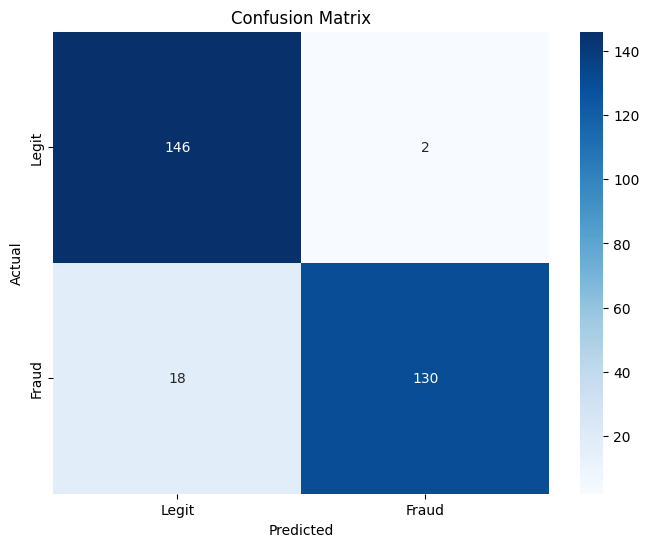

Classification Report:
              precision    recall  f1-score   support

       Legit       0.89      0.99      0.94       148
       Fraud       0.98      0.88      0.93       148

    accuracy                           0.93       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.93      0.93       296


Epoch 17: Train Loss: 0.0139, Train AUC: 0.9772, Test AUC: 0.9718
Epoch: 18 [0/688 (0%)]	Loss: 0.012278


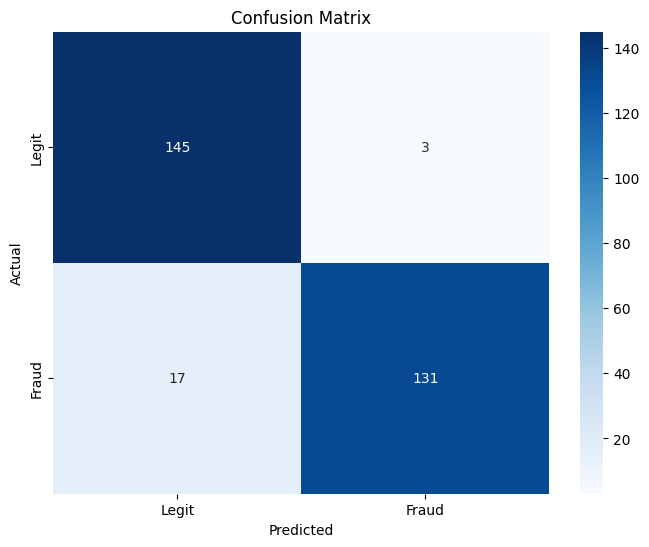

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.98      0.94       148
       Fraud       0.98      0.89      0.93       148

    accuracy                           0.93       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.93      0.93       296


Epoch 18: Train Loss: 0.0133, Train AUC: 0.9751, Test AUC: 0.9730
Epoch: 19 [0/688 (0%)]	Loss: 0.013615


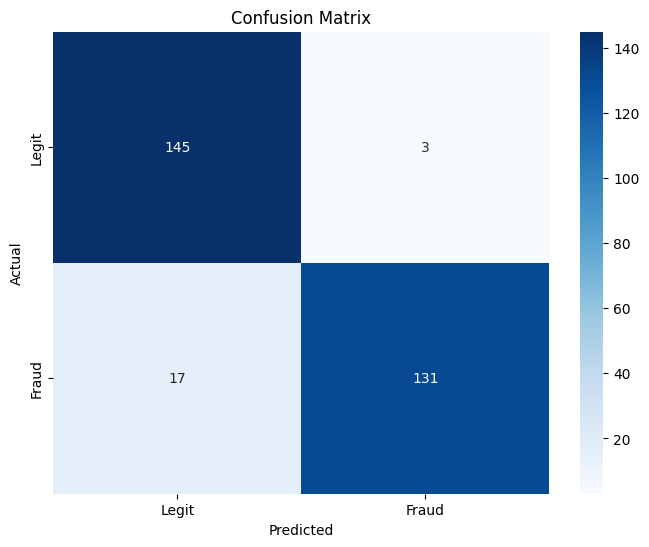

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.98      0.94       148
       Fraud       0.98      0.89      0.93       148

    accuracy                           0.93       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.93      0.93       296


Epoch 19: Train Loss: 0.0131, Train AUC: 0.9760, Test AUC: 0.9737
Epoch: 20 [0/688 (0%)]	Loss: 0.014330


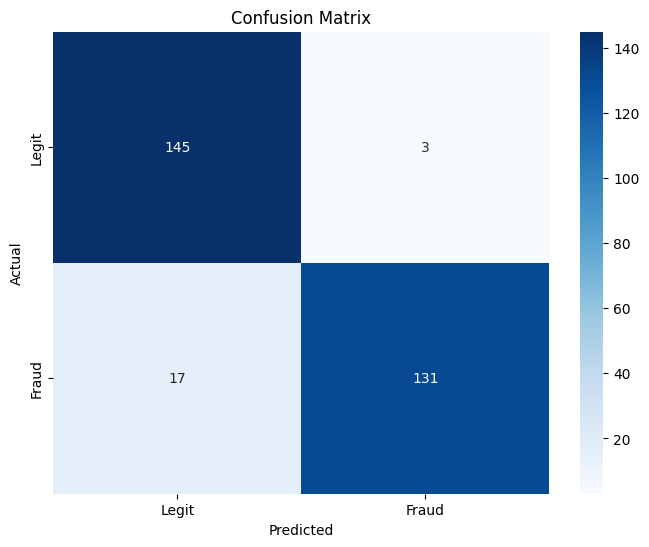

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.98      0.94       148
       Fraud       0.98      0.89      0.93       148

    accuracy                           0.93       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.93      0.93       296


Epoch 20: Train Loss: 0.0130, Train AUC: 0.9739, Test AUC: 0.9743
Epoch: 21 [0/688 (0%)]	Loss: 0.012075


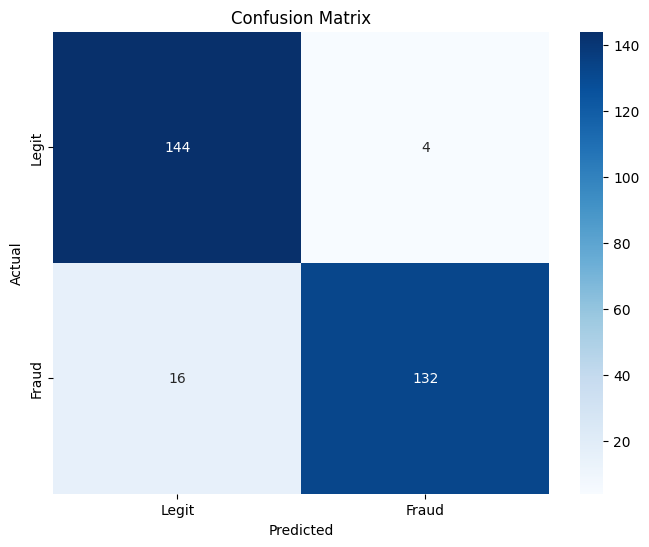

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.97      0.94       148
       Fraud       0.97      0.89      0.93       148

    accuracy                           0.93       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.93      0.93       296


Epoch 21: Train Loss: 0.0118, Train AUC: 0.9796, Test AUC: 0.9745
Epoch: 22 [0/688 (0%)]	Loss: 0.010055


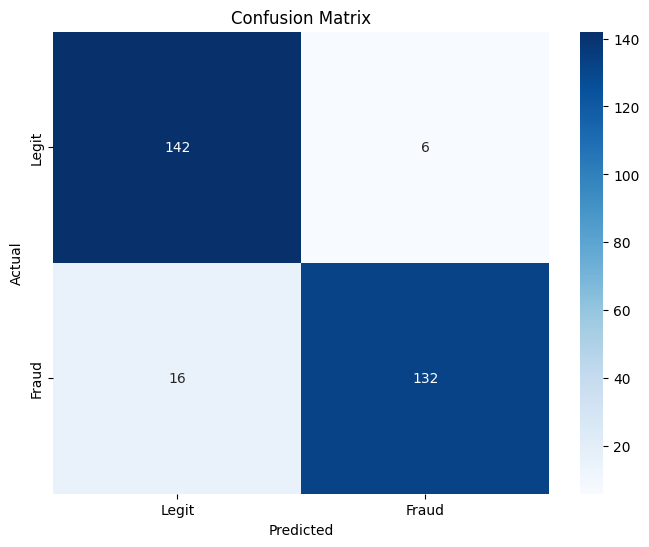

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.96      0.93       148
       Fraud       0.96      0.89      0.92       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 22: Train Loss: 0.0123, Train AUC: 0.9792, Test AUC: 0.9748
Epoch: 23 [0/688 (0%)]	Loss: 0.011528


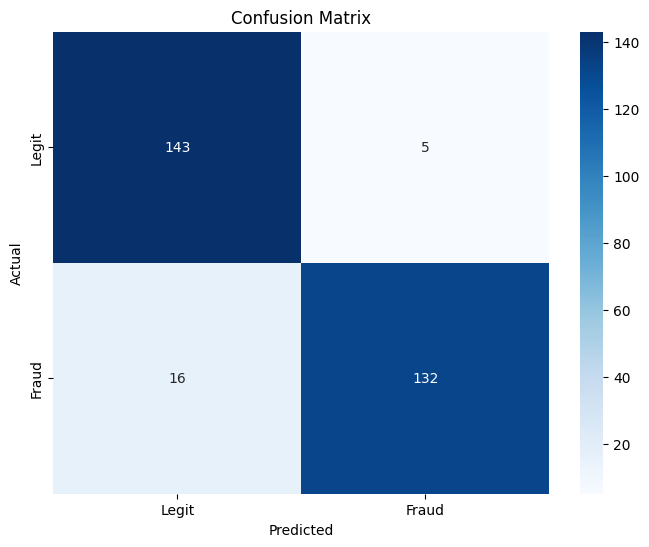

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.97      0.93       148
       Fraud       0.96      0.89      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 23: Train Loss: 0.0122, Train AUC: 0.9782, Test AUC: 0.9749
Epoch: 24 [0/688 (0%)]	Loss: 0.009251


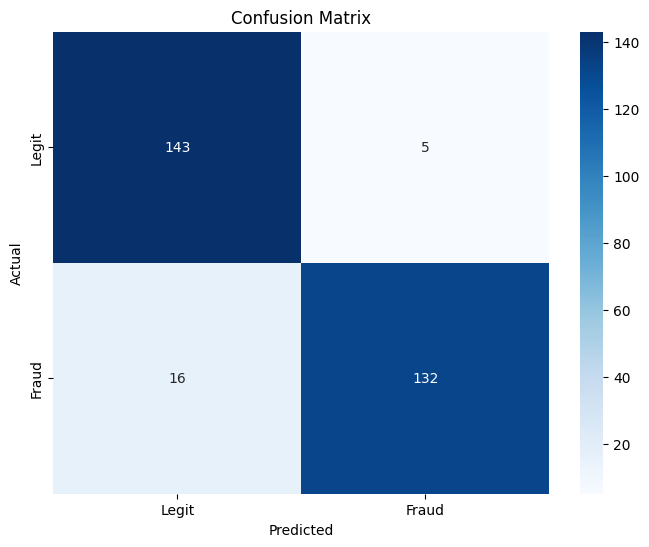

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.97      0.93       148
       Fraud       0.96      0.89      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 24: Train Loss: 0.0112, Train AUC: 0.9788, Test AUC: 0.9747
Epoch: 25 [0/688 (0%)]	Loss: 0.009526


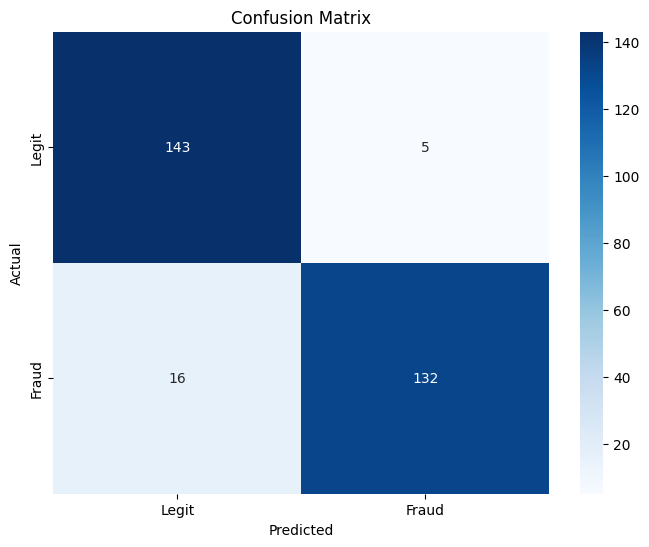

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.97      0.93       148
       Fraud       0.96      0.89      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 25: Train Loss: 0.0106, Train AUC: 0.9846, Test AUC: 0.9745
Epoch: 26 [0/688 (0%)]	Loss: 0.013469


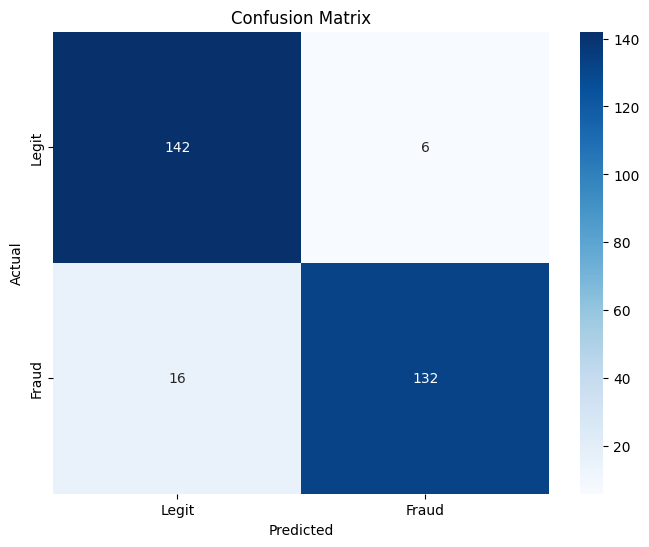

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.96      0.93       148
       Fraud       0.96      0.89      0.92       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 26: Train Loss: 0.0117, Train AUC: 0.9785, Test AUC: 0.9744
Epoch: 27 [0/688 (0%)]	Loss: 0.009714


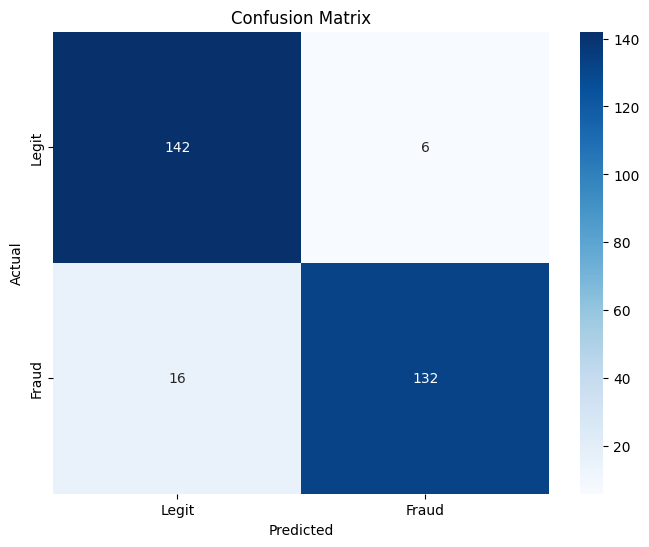

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.96      0.93       148
       Fraud       0.96      0.89      0.92       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 27: Train Loss: 0.0111, Train AUC: 0.9805, Test AUC: 0.9745
Epoch: 28 [0/688 (0%)]	Loss: 0.008790


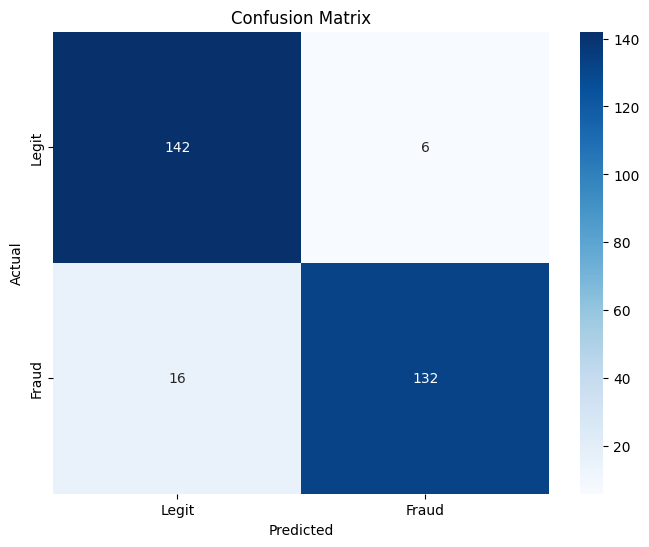

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.96      0.93       148
       Fraud       0.96      0.89      0.92       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 28: Train Loss: 0.0101, Train AUC: 0.9854, Test AUC: 0.9742
Epoch: 29 [0/688 (0%)]	Loss: 0.011861


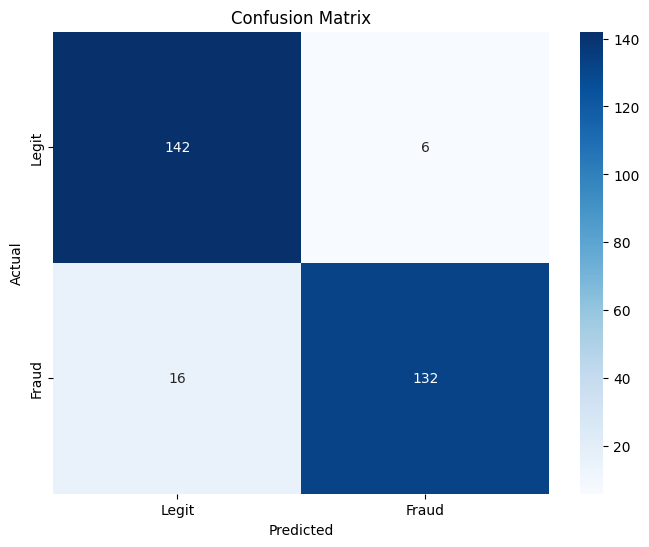

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.96      0.93       148
       Fraud       0.96      0.89      0.92       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 29: Train Loss: 0.0111, Train AUC: 0.9804, Test AUC: 0.9742
Epoch: 30 [0/688 (0%)]	Loss: 0.010750


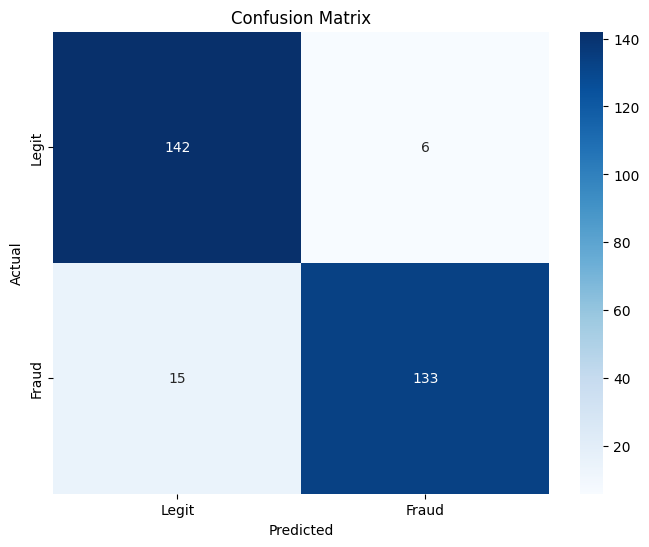

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.96      0.93       148
       Fraud       0.96      0.90      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 30: Train Loss: 0.0101, Train AUC: 0.9833, Test AUC: 0.9743
Epoch: 31 [0/688 (0%)]	Loss: 0.011412


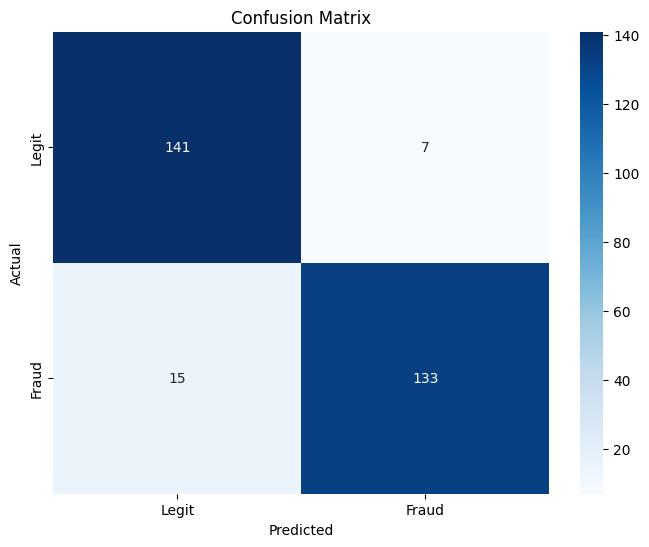

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.95      0.93       148
       Fraud       0.95      0.90      0.92       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 31: Train Loss: 0.0108, Train AUC: 0.9796, Test AUC: 0.9749
Epoch: 32 [0/688 (0%)]	Loss: 0.006681


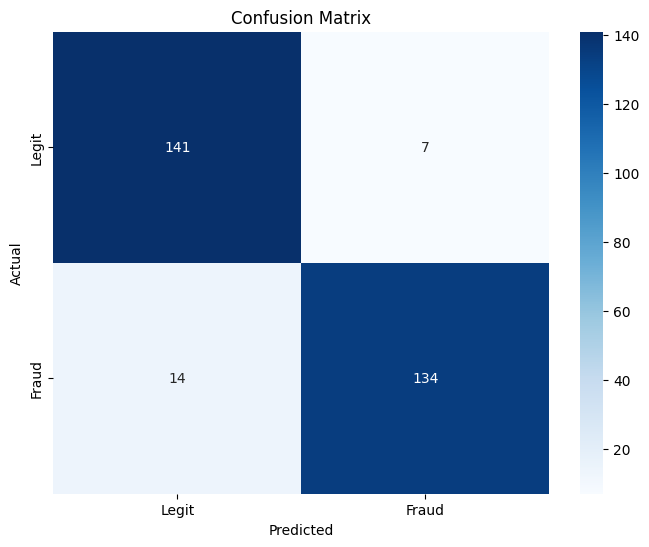

Classification Report:
              precision    recall  f1-score   support

       Legit       0.91      0.95      0.93       148
       Fraud       0.95      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 32: Train Loss: 0.0090, Train AUC: 0.9904, Test AUC: 0.9754
Epoch: 33 [0/688 (0%)]	Loss: 0.011122


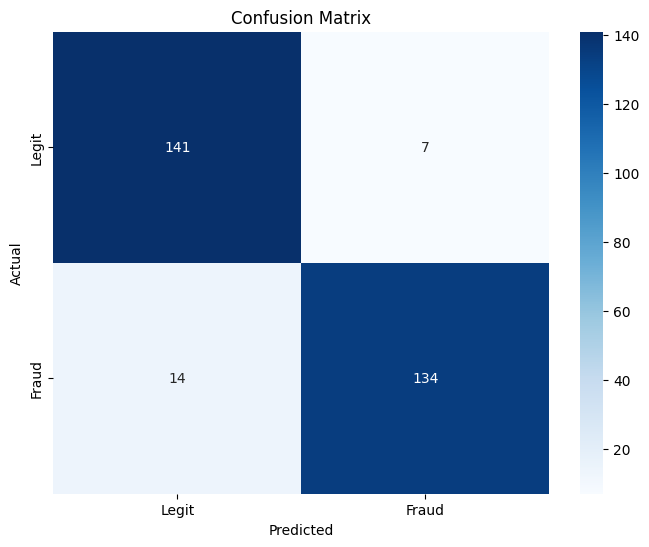

Classification Report:
              precision    recall  f1-score   support

       Legit       0.91      0.95      0.93       148
       Fraud       0.95      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 33: Train Loss: 0.0100, Train AUC: 0.9828, Test AUC: 0.9755
Epoch: 34 [0/688 (0%)]	Loss: 0.009743


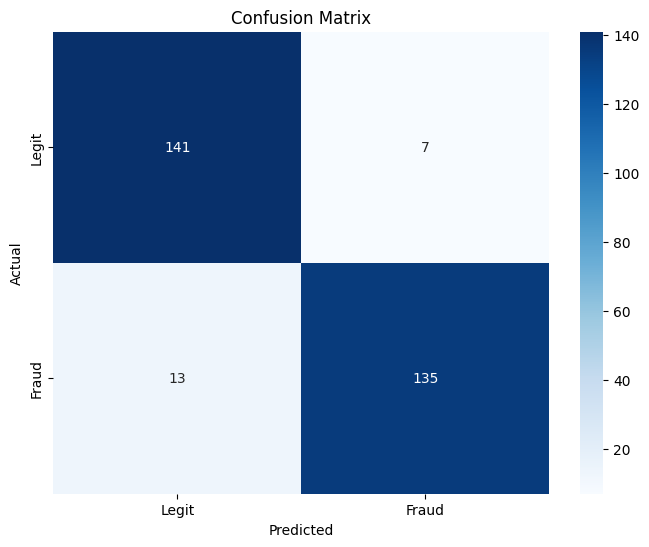

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.95      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 34: Train Loss: 0.0106, Train AUC: 0.9807, Test AUC: 0.9752
Epoch: 35 [0/688 (0%)]	Loss: 0.012055


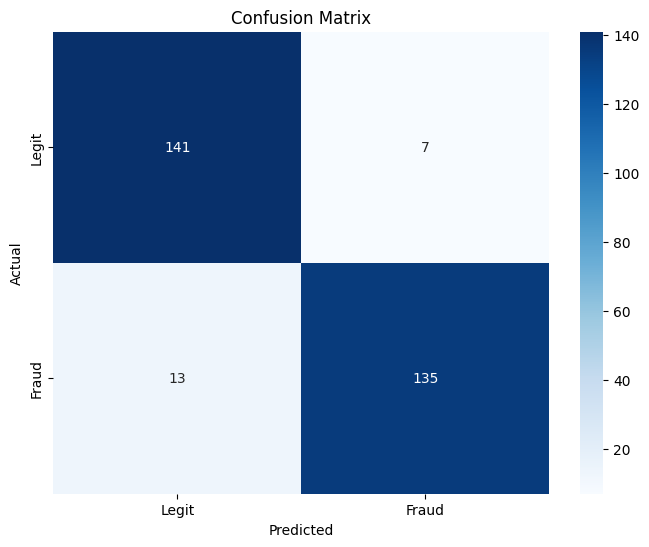

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.95      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 35: Train Loss: 0.0091, Train AUC: 0.9870, Test AUC: 0.9749
Epoch: 36 [0/688 (0%)]	Loss: 0.007864


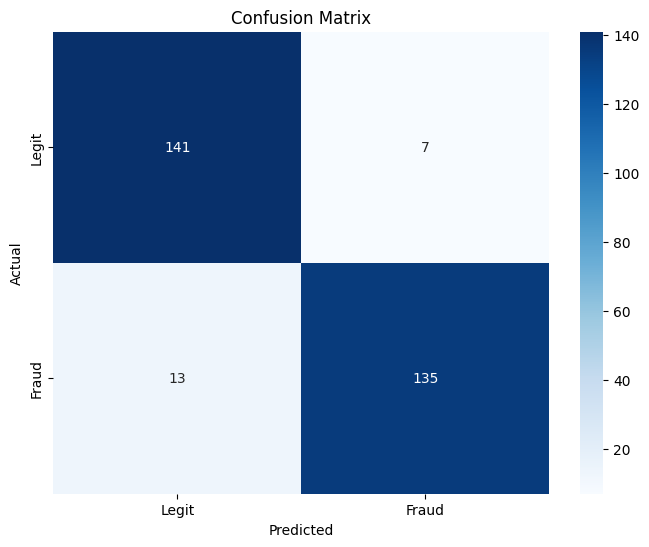

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.95      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 36: Train Loss: 0.0089, Train AUC: 0.9867, Test AUC: 0.9748
Epoch: 37 [0/688 (0%)]	Loss: 0.007680


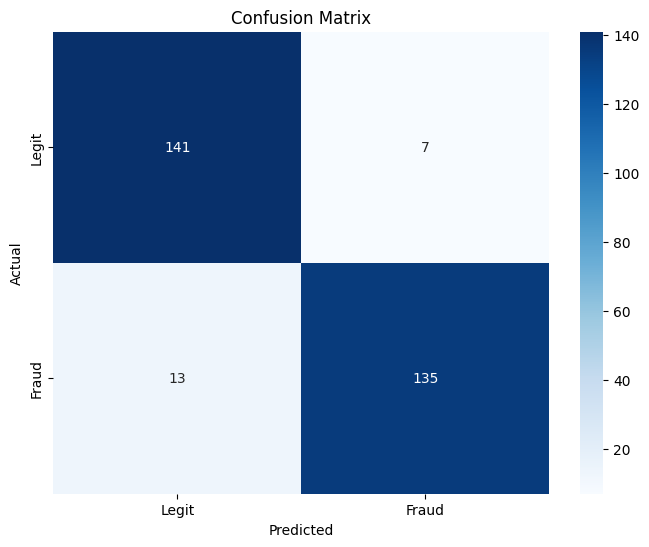

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.95      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 37: Train Loss: 0.0088, Train AUC: 0.9892, Test AUC: 0.9747
Epoch: 38 [0/688 (0%)]	Loss: 0.010961


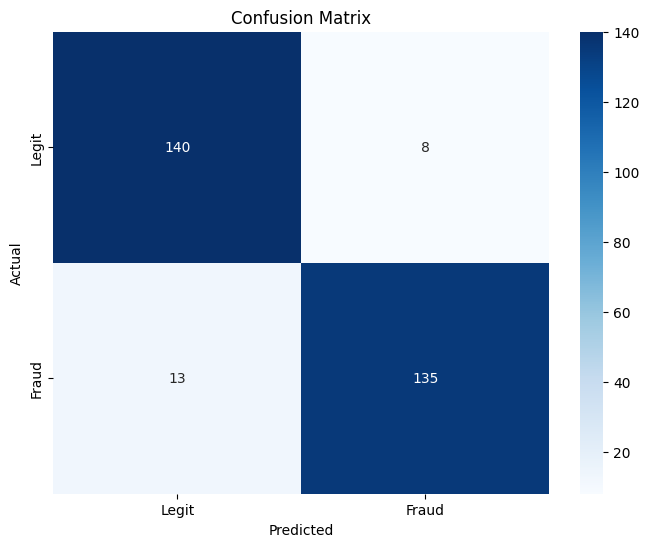

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.94      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 38: Train Loss: 0.0093, Train AUC: 0.9854, Test AUC: 0.9748
Epoch: 39 [0/688 (0%)]	Loss: 0.008575


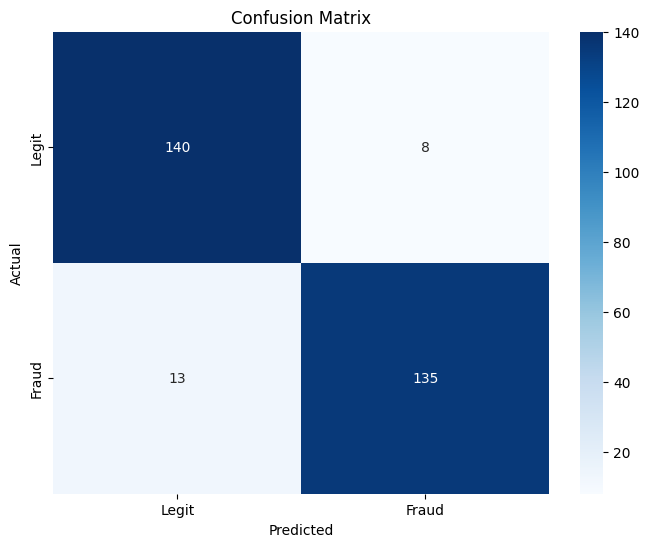

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.94      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 39: Train Loss: 0.0084, Train AUC: 0.9896, Test AUC: 0.9752
Epoch: 40 [0/688 (0%)]	Loss: 0.007521


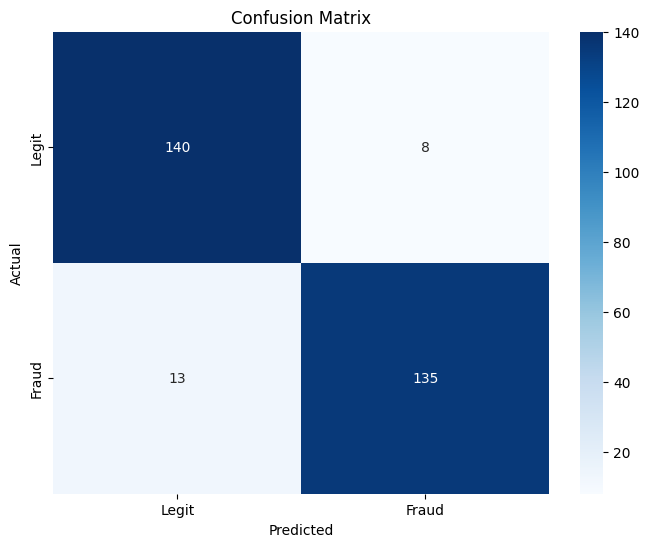

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.94      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 40: Train Loss: 0.0078, Train AUC: 0.9884, Test AUC: 0.9751
Epoch: 41 [0/688 (0%)]	Loss: 0.007792


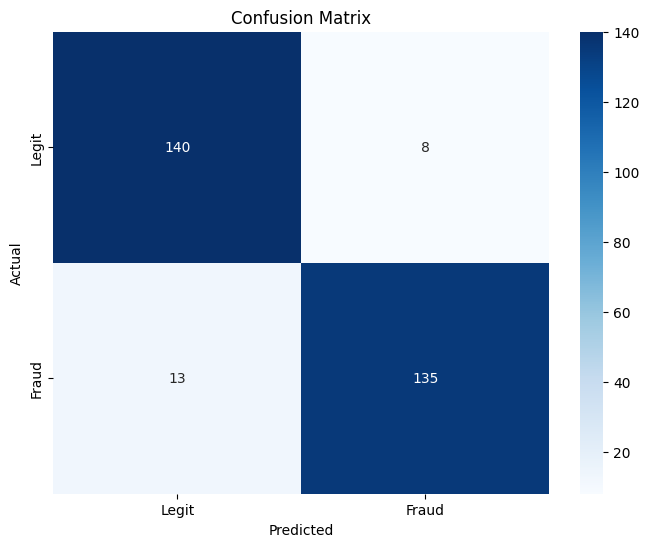

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.94      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 41: Train Loss: 0.0102, Train AUC: 0.9833, Test AUC: 0.9755
Epoch: 42 [0/688 (0%)]	Loss: 0.007825


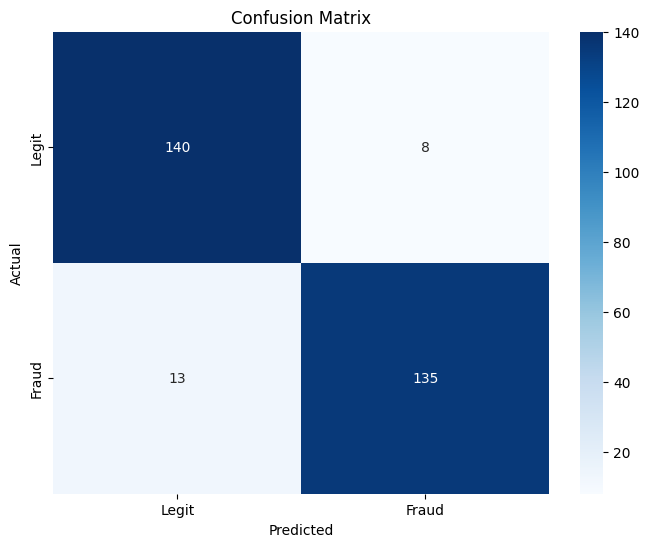

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.94      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 42: Train Loss: 0.0078, Train AUC: 0.9920, Test AUC: 0.9754
Epoch: 43 [0/688 (0%)]	Loss: 0.007892


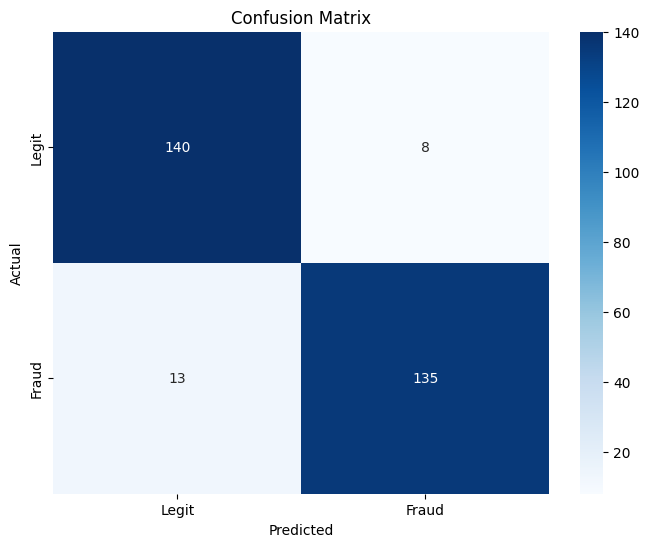

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.94      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 43: Train Loss: 0.0095, Train AUC: 0.9850, Test AUC: 0.9753
Epoch: 44 [0/688 (0%)]	Loss: 0.007891


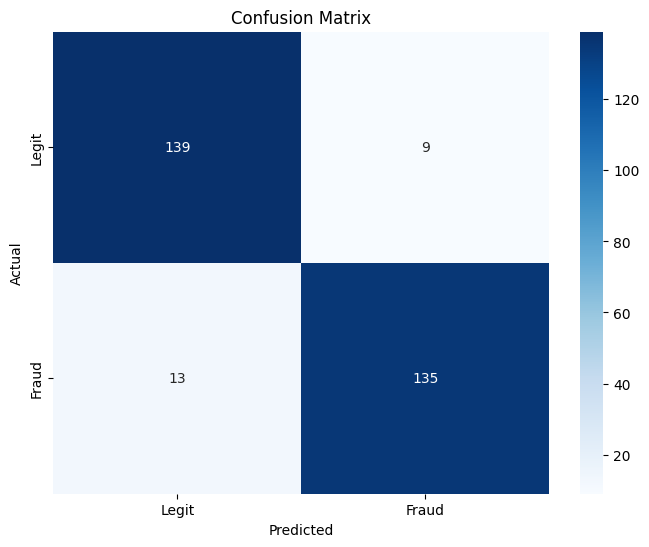

Classification Report:
              precision    recall  f1-score   support

       Legit       0.91      0.94      0.93       148
       Fraud       0.94      0.91      0.92       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 44: Train Loss: 0.0076, Train AUC: 0.9914, Test AUC: 0.9753
Epoch: 45 [0/688 (0%)]	Loss: 0.009477


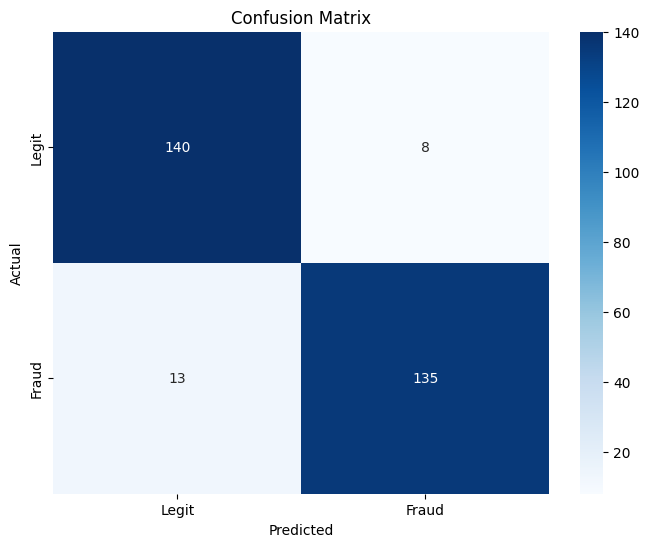

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.94      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 45: Train Loss: 0.0086, Train AUC: 0.9859, Test AUC: 0.9755
Epoch: 46 [0/688 (0%)]	Loss: 0.008444


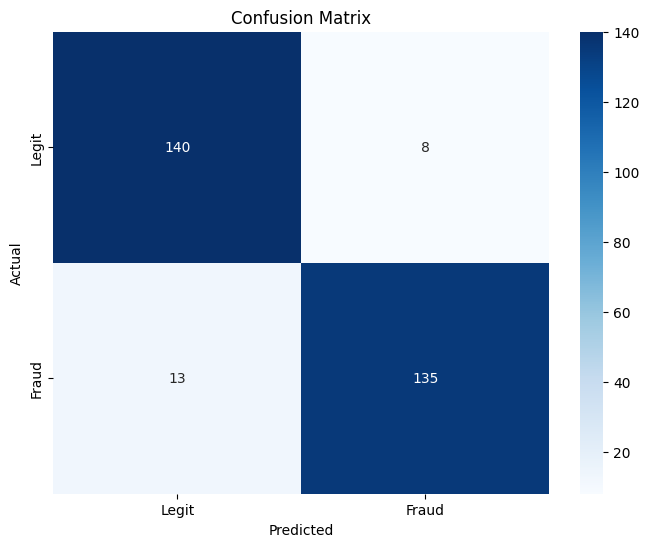

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.94      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 46: Train Loss: 0.0079, Train AUC: 0.9901, Test AUC: 0.9756
Epoch: 47 [0/688 (0%)]	Loss: 0.009412


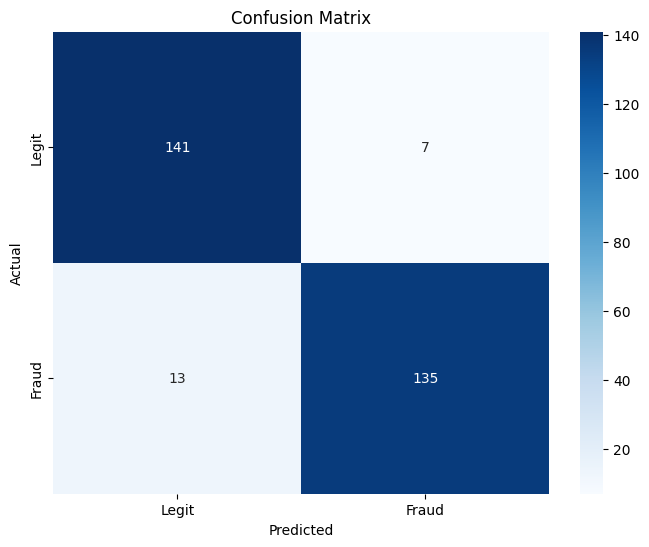

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.95      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 47: Train Loss: 0.0081, Train AUC: 0.9890, Test AUC: 0.9754
Epoch: 48 [0/688 (0%)]	Loss: 0.008338


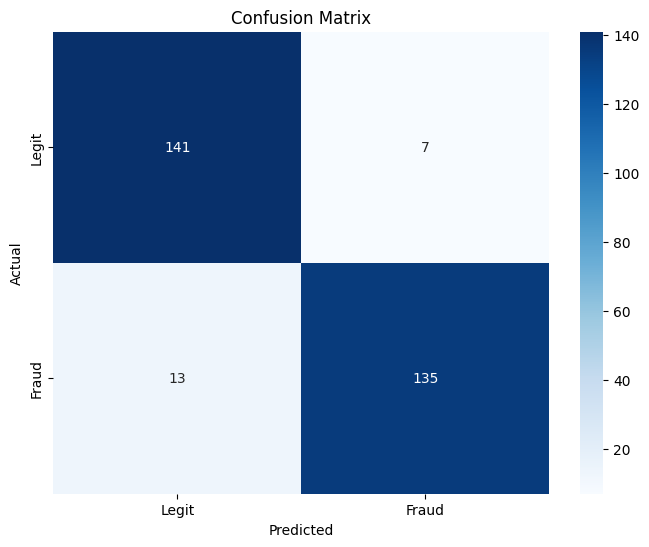

Classification Report:
              precision    recall  f1-score   support

       Legit       0.92      0.95      0.93       148
       Fraud       0.95      0.91      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 48: Train Loss: 0.0073, Train AUC: 0.9918, Test AUC: 0.9753
Epoch: 49 [0/688 (0%)]	Loss: 0.006899


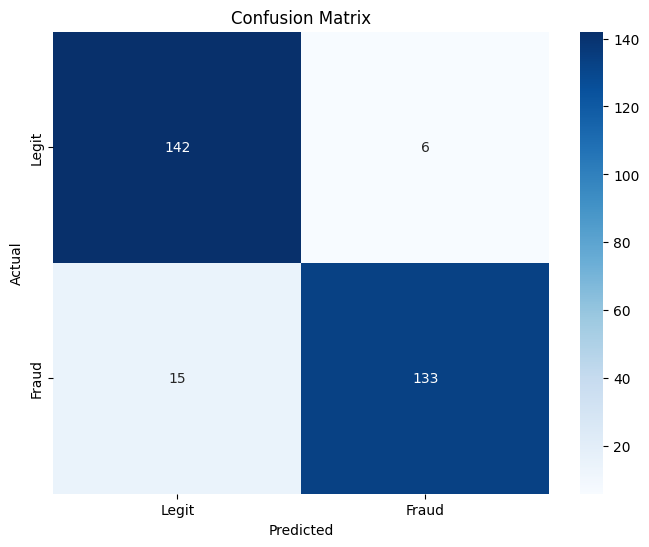

Classification Report:
              precision    recall  f1-score   support

       Legit       0.90      0.96      0.93       148
       Fraud       0.96      0.90      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 49: Train Loss: 0.0069, Train AUC: 0.9928, Test AUC: 0.9752
Epoch: 50 [0/688 (0%)]	Loss: 0.007764


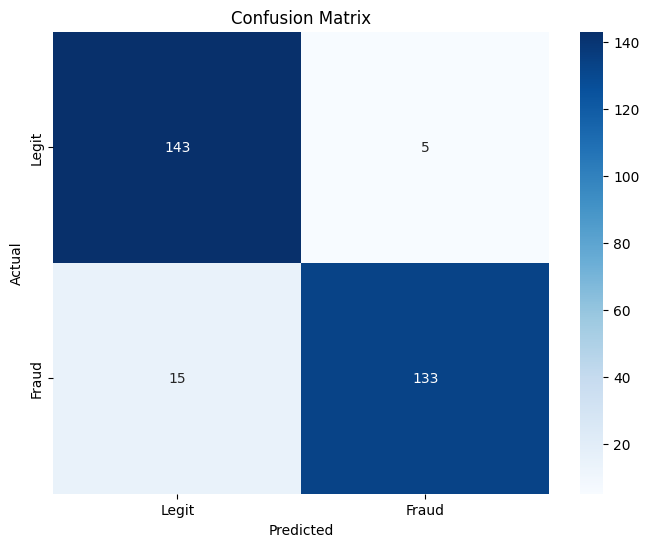

Classification Report:
              precision    recall  f1-score   support

       Legit       0.91      0.97      0.93       148
       Fraud       0.96      0.90      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Epoch 50: Train Loss: 0.0068, Train AUC: 0.9927, Test AUC: 0.9750


In [ ]:
# Step 11: Train and evaluate
print("\nStarting training...")
train_aucs = []
test_aucs = []
train_losses = []

for epoch in range(1, 51):
    train_loss, train_auc = train(epoch)
    test_auc, _ = evaluate(test_loader)  # Now returns values

    train_losses.append(train_loss)
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)

    print(f'\nEpoch {epoch:02d}: '
          f'Train Loss: {train_loss:.4f}, '
          f'Train AUC: {train_auc:.4f}, '
          f'Test AUC: {test_auc:.4f}')


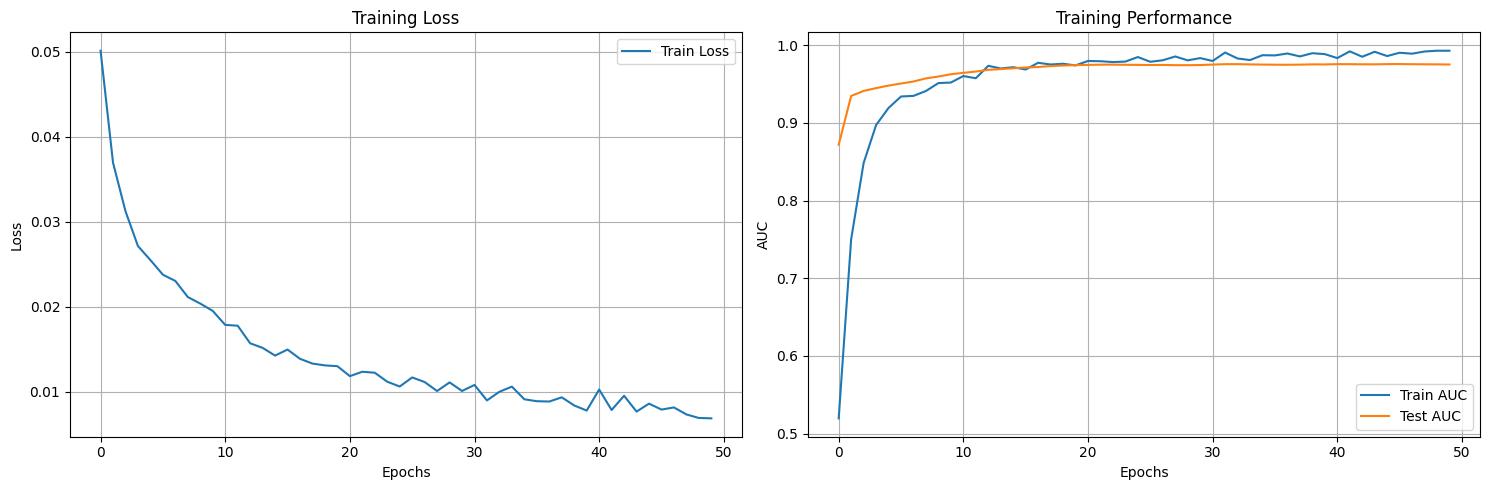

In [ ]:
# Step 12: Plot performance
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_aucs, label='Train AUC')
plt.plot(test_aucs, label='Test AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Step 13: Save model
model_path = 'credit_card_fraud_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'feature_cols': FEATURE_COLS,
    'input_size': len(FEATURE_COLS)
}, model_path)

print(f"Model saved successfully at {model_path}!")

Model saved successfully at credit_card_fraud_model.pth!


In [ ]:
# Step 14: Test with sample data
print("\nTesting with sample transaction...")
sample_data = test_df.iloc[0]
features = torch.tensor(sample_data[FEATURE_COLS].values, dtype=torch.float).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    prob = model(features)
print(f"Sample transaction fraud probability: {prob.item():.4f}")
print(f"Actual class: {sample_data['Class']}")


Testing with sample transaction...
Sample transaction fraud probability: 0.1154
Actual class: 0.0
